<a href="https://colab.research.google.com/github/fedeslandrix/fedeslandrix/blob/main/Primer_intento_flores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Primer intento con el dataset filtrado.
Se eligieron las imágenes de flores más nítidas y grandes.
11 clases, aproximadamente 10 imagenes por clase
El mejor modelo logró un val_accuracy de 0.57, mucho mejor que una clasificación aleatoria. Y el val_loss fue de 14.27

In [17]:
from pathlib import Path
import os

os.chdir('/content')

root = Path.cwd()
print(root)
root_ds = root / 'drive/MyDrive/Proyecto Flores IA/Flores Grandes 1 Bien limpio'

print(root_ds)


/content
/content/drive/MyDrive/Proyecto Flores IA/Flores Grandes 1 Bien limpio


In [22]:
import tensorflow as tf
from keras.utils import image_dataset_from_directory
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.layers import *
from keras.models import Sequential, Model
from keras.optimizers import AdamW
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt



base_model = ResNet50(weights='imagenet', input_shape=INPUT_SHAPE, include_top=False,)

In [19]:
IMG_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3)

VAL_FRACTION = 0.3

BATCH_SIZE = 1
train_ds = image_dataset_from_directory(
    directory=root_ds,
    validation_split=VAL_FRACTION,
    labels='inferred',             # Infiere las etiquetas del nombre de la carpeta
    label_mode='categorical',      # Convierte las etiquetas a One-Hot Encoding
    subset="training",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=123
)

val_ds = image_dataset_from_directory(
    directory=root_ds,
    validation_split=VAL_FRACTION,
    labels='inferred',             # Infiere las etiquetas del nombre de la carpeta
    label_mode='categorical',      # Convierte las etiquetas a One-Hot Encoding
    subset="validation",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=123
)

data_augmentation = Sequential([
        RandomFlip("horizontal"),
        RandomRotation(0.2),

        RandomZoom(0.3),

        RandomContrast(0.2),

        RandomTranslation(
            height_factor=0.1,
            width_factor=0.1,
            fill_mode='reflect' # Rellena los huecos con una reflexión de los bordes
        )
    ]
)


def my_model():
    inputs = Input(shape=INPUT_SHAPE, name="input_layer")

    x = data_augmentation(inputs)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.6)(x)
    output = Dense(11, activation='softmax', name="output_layer")(x)

    model = Model(inputs, output)

    model.compile(optimizer=AdamW(learning_rate=0.0001), loss="categorical_crossentropy", metrics=['accuracy'])

    return model


model = my_model()

model.summary()




Found 111 files belonging to 11 classes.
Using 78 files for training.
Found 111 files belonging to 11 classes.
Using 33 files for validation.


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 11)             │         5,643 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,642,443 (94.00 MB)

 Trainable params: 24,589,323 (93.80 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [20]:
# IMPORTANTE: Esta función (preprocess_input) espera que los valores de entrada sigan en el rango 0-255.

# Aplicar el preprocesamiento de ImageNet
def preprocess_for_resnet(image, label):
    return preprocess_input(image), label

train_ds = train_ds.map(preprocess_for_resnet)
val_ds = val_ds.map(preprocess_for_resnet)

In [21]:
history = model.fit(train_ds, epochs=100, validation_data=val_ds)

Epoch 1/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 69s 402ms/step - accuracy: 0.0636 - loss: 2.8779 - val_accuracy: 0.0606 - val_loss: 2.7650
Epoch 2/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - accuracy: 0.0560 - loss: 2.7681 - val_accuracy: 0.0303 - val_loss: 2.8467
Epoch 3/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - accuracy: 0.1038 - loss: 2.5573 - val_accuracy: 0.0303 - val_loss: 2.7276
Epoch 4/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - accuracy: 0.0970 - loss: 2.4584 - val_accuracy: 0.0909 - val_loss: 2.6979
Epoch 5/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - accuracy: 0.1470 - loss: 2.2432 - val_accuracy: 0.1212 - val_loss: 2.7399
Epoch 6/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - accuracy: 0.2366 - loss: 2.1739 - val_accuracy: 0.2121 - val_loss: 2.4618
Epoch 7/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - accuracy: 0.1739 - loss: 2.1285 - val_accuracy: 0.3333 - val_loss: 3.2626
Epoch 8/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - accuracy: 0.2822 - loss: 1.8965 - val_acc

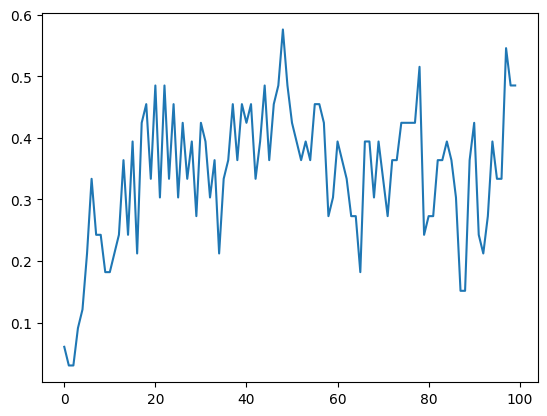

In [24]:

plt.plot(history.history['val_accuracy'])

plt.show()